<a href="https://colab.research.google.com/github/erichsiao1106/cnn/blob/master/lymphoma_transferlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
from glob import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import keras
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten
from keras.models import Model
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.


In [ ]:
IMG_SIZE = 200
class_map = {'CLL':0, 'MCL': 1, 'FL': 2}

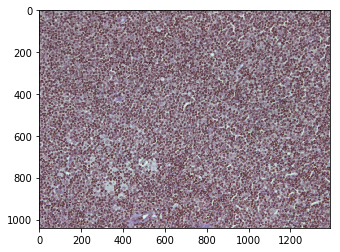

In [ ]:
# Read single image
data_path = 'drive/My Drive/class/北分署/week8/lymphoma/*/*.tif' 
img_paths = glob(data_path)
# img_paths = np.random.choice(img_paths, 100) # demo for 200 images
img = cv2.imread(img_paths[0])
plt.imshow(img)

((1040, 1388, 3), (200, 200, 3))

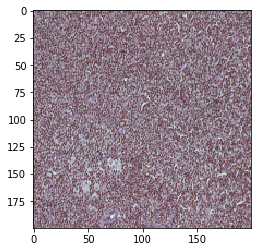

In [ ]:
# Resize img
img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
plt.imshow(img_resized)
img.shape, img_resized.shape

In [ ]:
# Extract img class
img_path = img_paths[0]
img_path

'drive/My Drive/class/緯育醫學影像/Day4/lymphoma/CLL/sj-05-3874-R2_001.tif'

In [ ]:
cls = img_path.split('/')[-2]
cls

'CLL'

In [ ]:
class_map[cls]

0

In [ ]:
data_count = len(img_paths)
X = np.zeros((data_count, IMG_SIZE, IMG_SIZE, 3))
y = np.zeros((data_count, ))

In [ ]:
for i, path in tqdm(enumerate(img_paths)):
    img = cv2.imread(path)
    img_resize = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    cls = path.split('/')[-2]
    
    X[i] = img_resize
    y[i] = class_map[cls]

In [ ]:
# label count
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

{0.0: 113, 1.0: 122, 2.0: 139}

In [ ]:
from keras.applications.inception_v3 import preprocess_input
X = preprocess_input(X)
y_onehot = keras.utils.to_categorical(y, num_classes=3)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=5566)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((299, 200, 200, 3), (75, 200, 200, 3), (299, 3), (75, 3))

In [ ]:
# 1
base_model = keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(base_model.input, predictions)

W0904 19:51:59.259081 140199732959104 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0904 19:51:59.281342 140199732959104 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0904 19:51:59.287714 140199732959104 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0904 19:51:59.309957 140199732959104 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0904 19:51:59.311276 1401997329

87916544/87910968 [==============================] - 3s 0us/step


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 99, 99, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 99, 99, 32)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

W0904 19:52:49.542806 140199732959104 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

checkpoint = ModelCheckpoint('drive/My Drive/ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)


In [ ]:

logs = model.fit(X_train, y_train,
                batch_size=32,
                epochs=100,
                verbose=1,
                callbacks=[early_stopping, reduce_lr],     
                validation_data=(X_test, y_test))

W0904 19:53:01.279892 140199732959104 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 299 samples, validate on 75 samples
Epoch 1/100
299/299 [==============================] - 24s 79ms/step - loss: 1.3985 - acc: 0.5017 - val_loss: 2.3876 - val_acc: 0.3733
Epoch 2/100
299/299 [==============================] - 6s 19ms/step - loss: 0.7669 - acc: 0.6355 - val_loss: 1.2342 - val_acc: 0.5600
Epoch 3/100
299/299 [==============================] - 6s 19ms/step - loss: 0.6603 - acc: 0.7458 - val_loss: 1.3914 - val_acc: 0.5600
Epoch 4/100
299/299 [==============================] - 6s 19ms/step - loss: 0.4798 - acc: 0.8462 - val_loss: 2.4067 - val_acc: 0.5067
Epoch 5/100
299/299 [==============================] - 6s 19ms/step - loss: 0.5630 - acc: 0.7726 - val_loss: 5.6849 - val_acc: 0.4400

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/100
299/299 [==============================] - 6s 19ms/step - loss: 0.4111 - acc: 0.8227 - val_loss: 2.2621 - val_acc: 0.6667
Epoch 7/100
299/299 [==============================] - 6s 19ms/step 

In [ ]:
history = logs.history

Text(0.5, 1.0, 'acc')

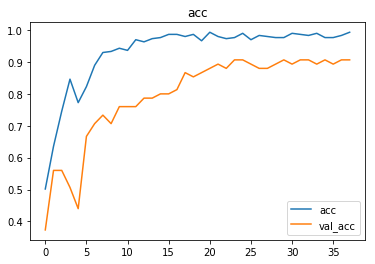

In [ ]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.title('acc')

Text(0.5, 1.0, 'loss')

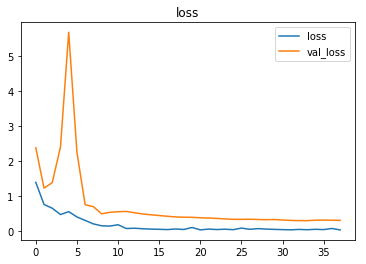

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_true = np.argmax(y_test, axis=-1)
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(y_true.shape, y_pred.shape)
target_names = [str(i) for i in range(3)]
print(classification_report(y_true, y_pred, target_names=target_names))
print(confusion_matrix(y_true, y_pred))


(75,) (75,)
              precision    recall  f1-score   support

           0       0.89      0.84      0.86        19
           1       0.96      0.90      0.93        29
           2       0.87      0.96      0.91        27

    accuracy                           0.91        75
   macro avg       0.91      0.90      0.90        75
weighted avg       0.91      0.91      0.91        75

[[16  1  2]
 [ 1 26  2]
 [ 1  0 26]]
